In [9]:
import tensorflow
tensorflow.__version__

'2.3.0'

----

## 8.300 Neural style transfer

The aim is to apply the *style* of one image to the *content* of another image.

Style = textures, colours, visual patterns

Content = high level macrostructure

E.g. apply van Gogh-like brushstrokes to a photograph

![style transfer](https://s3.amazonaws.com/book.keras.io/img/ch8/style_transfer.png)

----

## 8.310 Content and style loss

##### How?

Always: define a loss fuction for what you wish to achieve and then minimise

loss = distance(style(reference_image), style(generated_image))

+

distance(content(original_image), content(generated_image))

##### Yes, but how?

The upper layers contain global information - macrostructure or content

Content loss is L2 norm (distance)

content => activation on the upper layer of a pretrained convnet



Style loss is tricky

The aim is to capture the appearance of the target image at all spatial scales 



Style loss aims to preserve the *correlations* between activations of different layers

The idea is that textures are represented as correlations at different scales

----

## 8.330 Implementing neural style transfer

1. Use a pretrained convnet e.g. VGG19 (VGG16 + 3 extra conv. layers)
2. Compute the layer activations for the style-reference image, the original image and the generated image
3. Minimise the loss with gradient descent

The notebook code is from the DLWP 2nd edition code archive: 

https://github.com/fchollet/deep-learning-with-python-notebooks/blob/master/chapter12_part03_neural-style-transfer.ipynb§m

In [1]:
from tensorflow import keras

base_image_path = keras.utils.get_file(
    "sf.jpg", origin="https://img-datasets.s3.amazonaws.com/sf.jpg")
style_reference_image_path = keras.utils.get_file(
    "starry_night.jpg", origin="https://img-datasets.s3.amazonaws.com/starry_night.jpg")

original_width, original_height = keras.preprocessing.image.load_img(base_image_path).size
img_height = 400
img_width = round(original_width * img_height / original_height)

In [2]:
import numpy as np

def preprocess_image(image_path):
    img = keras.preprocessing.image.load_img(
        image_path, target_size=(img_height, img_width))
    img = keras.preprocessing.image.img_to_array(img)
    img = np.expand_dims(img, axis=0)
    img = keras.applications.vgg19.preprocess_input(img)
    return img

def deprocess_image(img):
    img = img.reshape((img_height, img_width, 3))
    img[:, :, 0] += 103.939
    img[:, :, 1] += 116.779
    img[:, :, 2] += 123.68
    img = img[:, :, ::-1]
    img = np.clip(img, 0, 255).astype("uint8")
    return img

In [3]:
model = keras.applications.vgg19.VGG19(weights="imagenet", include_top=False)

outputs_dict = dict([(layer.name, layer.output) for layer in model.layers])
feature_extractor = keras.Model(inputs=model.inputs, outputs=outputs_dict)

In [4]:
def content_loss(base_img, combination_img):
    return tf.reduce_sum(tf.square(combination_img - base_img))

In [5]:
def gram_matrix(x):
    x = tf.transpose(x, (2, 0, 1))
    features = tf.reshape(x, (tf.shape(x)[0], -1))
    gram = tf.matmul(features, tf.transpose(features))
    return gram

def style_loss(style_img, combination_img):
    S = gram_matrix(style_img)
    C = gram_matrix(combination_img)
    channels = 3
    size = img_height * img_width
    return tf.reduce_sum(tf.square(S - C)) / (4.0 * (channels ** 2) * (size ** 2))

In [6]:
def total_variation_loss(x):
    a = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, 1:, : img_width - 1, :]
    )
    b = tf.square(
        x[:, : img_height - 1, : img_width - 1, :] - x[:, : img_height - 1, 1:, :]
    )
    return tf.reduce_sum(tf.pow(a + b, 1.25))

In [7]:
style_layer_names = [
    "block1_conv1",
    "block2_conv1",
    "block3_conv1",
    "block4_conv1",
    "block5_conv1",
]
content_layer_name = "block5_conv2"
total_variation_weight = 1e-6
style_weight = 1e-6
content_weight = 2.5e-8

def compute_loss(combination_image, base_image, style_reference_image):
    input_tensor = tf.concat(
        [base_image, style_reference_image, combination_image], axis=0
    )
    features = feature_extractor(input_tensor)
    loss = tf.zeros(shape=())
    layer_features = features[content_layer_name]
    base_image_features = layer_features[0, :, :, :]
    combination_features = layer_features[2, :, :, :]
    loss = loss + content_weight * content_loss(
        base_image_features, combination_features
    )
    for layer_name in style_layer_names:
        layer_features = features[layer_name]
        style_reference_features = layer_features[1, :, :, :]
        combination_features = layer_features[2, :, :, :]
        style_loss_value = style_loss(
          style_reference_features, combination_features)
        loss += (style_weight / len(style_layer_names)) * style_loss_value

    loss += total_variation_weight * total_variation_loss(combination_image)
    return loss

In [8]:
import tensorflow as tf

@tf.function
def compute_loss_and_grads(combination_image, base_image, style_reference_image):
    with tf.GradientTape() as tape:
        loss = compute_loss(combination_image, base_image, style_reference_image)
    grads = tape.gradient(loss, combination_image)
    return loss, grads

optimizer = keras.optimizers.SGD(
    keras.optimizers.schedules.ExponentialDecay(
        initial_learning_rate=100.0, decay_steps=100, decay_rate=0.96
    )
)

base_image = preprocess_image(base_image_path)
style_reference_image = preprocess_image(style_reference_image_path)
combination_image = tf.Variable(preprocess_image(base_image_path))

iterations = 4000
for i in range(1, iterations + 1):
    loss, grads = compute_loss_and_grads(
        combination_image, base_image, style_reference_image
    )
    optimizer.apply_gradients([(grads, combination_image)])
    if i % 100 == 0:
        print(f"Iteration {i}: loss={loss:.2f}")
        img = deprocess_image(combination_image.numpy())
        fname = f"combination_image_at_iteration_{i}.png"
        keras.preprocessing.image.save_img(fname, img)

KeyboardInterrupt: 

Results: 100th iteration

In [ ]:
import matplotlib.pyplot as plt
plt.axis("off")
image_path = '/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/Notebooks/8-generative-deep-learning/combination_image_at_iteration_100.png'

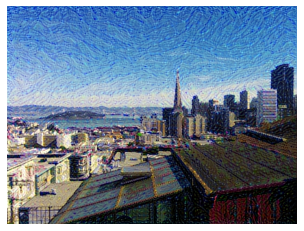

In [11]:
plt.imshow(keras.preprocessing.image.load_img(image_path))

In [ ]:
image_path = '/Users/timblackwell/Documents/Goldsmiths/2021/Data Science/Notebooks/8-generative-deep-learning/combination_image_at_iteration_1700.png'

1700th iteration

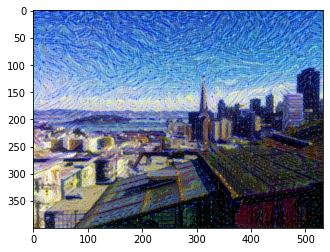

In [12]:
plt.imshow(keras.preprocessing.image.load_img(image_path))

----

## 8.340 Wrapping up

* Style transfer adorns the contents of a target image with style of a reference image
* Content can be captured by the high-level activations of a convnet


* Style can be captured by the internal correlations of the activations of different layers of a convnet
* An optimization process with a special loss
* There are many variants and refinements

----